# Shady streets: Route-finding in the shade
Idea: build a route finder that finds the shortest path with the most shade - perfect tool for navigating by bike or by foot during a heatwave. Of course, someone has already done this, using LiDAR data: https://www.allnans.com/jekyll/update/2018/08/07/introducing-parasol.html

# Data prep
* read and clip tree raster data to 10km box around Delft, convert to shpfile (?)
* read and clip cycling and pedestrian path data to 10km box around Delft, covert to shpfile (?)
* more on raster and vector data: https://carpentries-incubator.github.io/geospatial-python/aio/index.html

In [1]:
import geopandas as gpd
import rasterio 
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Reading and clipping tree data
* Go to https://www.atlasleefomgeving.nl/kaarten, search 'bomen'
* rasterio clipping tutorial: https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

In [2]:
# read original geotiff of whole NL
fp = 'data/20200629_gm_Bomenkaart_v2.tif'
out_tif = 'data/trees_delft.tif'

data = rasterio.open(fp)

print('number of bands: {}'.format(data.count))
print('crs: {}'.format(data.crs))
print('image resolution: {} x {} (10m pixels)'.format(data.height, data.width))
print('n pixels: {} million'.format((data.height*data.width)/1000000))

number of bands: 1
crs: EPSG:28992
image resolution: 31000 x 26603 (10m pixels)
n pixels: 824.693 million


In [3]:
# create bounding box for delft

# coordinates for delft (crs = amersfoort)
x = 84557.30 
y = 447475.53

# create bounding box
minx, miny = x-2500, y-2500
maxx, maxy = x+2500, y+2500
from shapely.geometry import box
bbox = box(minx, miny, maxx, maxy)

# insert bbox into gdf
bboxGdf = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=28992)

In [4]:
# clip raster 

# parse bbox into rasterio compatable format
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such 
    a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# clip original raster with Delft bbox
from rasterio.mask import mask
coords = getFeatures(bboxGdf)
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

In [5]:
# update meta-data
out_meta = data.meta.copy()
epsg_code = int(data.crs.data['init'][5:])

out_meta.update({
    'driver': 'GTiff', 
    'height': out_img.shape[1], 
    'width': out_img.shape[2], 
    'transform': out_transform
})

In [6]:
# write new clipped delft geotiff 
with rasterio.open(out_tif, 'w', **out_meta) as dest: 
    dest.write(out_img)

In [7]:
fp = 'data/trees_delft.tif'
delftTrees = rasterio.open(fp)

In [8]:
import numpy as np
print('number of bands: {}'.format(delftTrees.count))
print('crs: {}'.format(delftTrees.crs))
print('image resolution: {} x {} (10m pixels)'.format(delftTrees.height, delftTrees.width))
print('n pixels: {} million'.format(round((delftTrees.height*delftTrees.width)/1000000, 2)))
print('n non-zero pixels: {} thousand'.format(round(np.count_nonzero(delftTrees.read(1) > -9000)/1000)))

number of bands: 1
crs: EPSG:28992
image resolution: 501 x 501 (10m pixels)
n pixels: 0.25 million
n non-zero pixels: 113 thousand


# Converting into tree raster data into shpfile
* convert raster to geoDataFrame while maintaining same crs 
    * https://gis.stackexchange.com/questions/379412/how-to-create-a-geopandas-geodataframe-from-rasterio-features 
* gdf is inverted, so flipped using affine_transform, see discussion here: https://stackoverflow.com/questions/70152586/geodataframe-is-inverted-when-i-converted-from-raster-to-vector-using-rasterio

In [2]:
dataFile = rasterio.open('data/trees_delft.tif')
treeArray = dataFile.read(1)

In [3]:
%%time 
import rasterio.features
from shapely.geometry import shape

# read the shapes as separate lists
shapes = rasterio.features.shapes(treeArray, transform=dataFile.transform)
trees = []
geometry = []
for shapedict, value in shapes:
    trees.append(value)
    geometry.append(shape(shapedict))

CPU times: total: 2.88 s
Wall time: 2.95 s


In [4]:
%%time
# build the gdf object over the two lists
gdf = gpd.GeoDataFrame(
    {'trees': trees, 'geometry': geometry}, crs="EPSG:28992"
)
gdf = gdf[gdf.trees > 0]
treePts = gdf.copy()
treePts.geometry = treePts.geometry.centroid

CPU times: total: 438 ms
Wall time: 443 ms


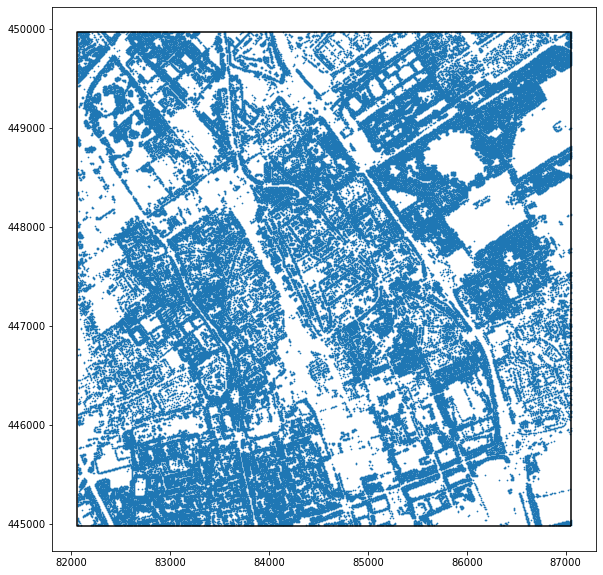

CPU times: total: 6.86 s
Wall time: 6.82 s


In [77]:
%%time
fig, ax = plt.subplots(1,1,figsize=(10,10))

treePts.plot(markersize=0.5, ax=ax)
bboxGdf.boundary.plot(ax=ax, color='black')

plt.show()

In [5]:
# save as shpfile
treePts.to_file("data/trees_delft.shp")

C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Problem (solved): wrong coordinates for resulting goeDataFrame
When making the geodataframe, the crs was right, but the coordinates were wrong. 

### Troubleshooting 1: maybe the raster has wrong coordinates after cropping? 
Answer: no. I plotted the raster (as np.array) together with the bounding box (bbox), and they fit perfectly together. The coordinates (seen on axes) are correct for Delft.

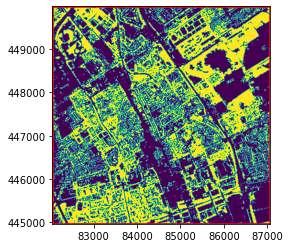

In [39]:
from rasterio import plot as rasterplot

# this is how you'd open the raster dataset if you have one
fp = 'data/trees_delft.tif'
dataFile = rasterio.open(fp)
tiff_extent = [dataFile.bounds[0], dataFile.bounds[2], dataFile.bounds[1], dataFile.bounds[3]]

f, ax = plt.subplots()
rasterplot.show(treeArray, extent=tiff_extent, ax=ax)
bboxGdf.boundary.plot(ax=ax, edgecolor='red')
plt.show()

### Troubleshooting 2: something went wrong with `rasterio.features.shapes(treeArray)`?
**YES, THAT WAS THE PROBLEM!** 

I needed to specify the transform, like this: `shapes = rasterio.features.shapes(treeArray, transform=dataFile.transform)`. More info [here](https://rasterio.readthedocs.io/en/stable/topics/features.html#extracting-shapes-of-raster-features) and [here (see section 'working between representations')](https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html#working-between-representations) 

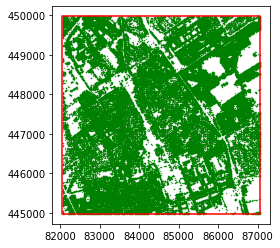

CPU times: total: 6.92 s
Wall time: 6.94 s


In [56]:
%%time
fig, ax = plt.subplots()
treePts.plot(markersize=0.1, ax=ax, color='green')
bboxGdf.boundary.plot(ax=ax, color='red')
plt.show()

# Reading cycling network data
* download cycling network of Delft, using same bbox as tree data 
* save data as shpfile (or better format?)

Handy osmnx links:
* [blog](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
* [documentation](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
* [github, example notebooks](https://github.com/gboeing/osmnx-examples)

In [42]:
import osmnx as ox

In [43]:
# make bbox with latlong coordinates (crs=WGS84)
bboxLatLong = bboxGdf.copy()
bboxLatLong = bboxLatLong.to_crs('EPSG:4326')
bounds = bboxLatLong.geometry.bounds

# get coordinates for lat long bbox 
north = bounds.loc[0, 'maxy']
south = bounds.loc[0, 'miny']
east = bounds.loc[0, 'maxx']
west = bounds.loc[0, 'minx']

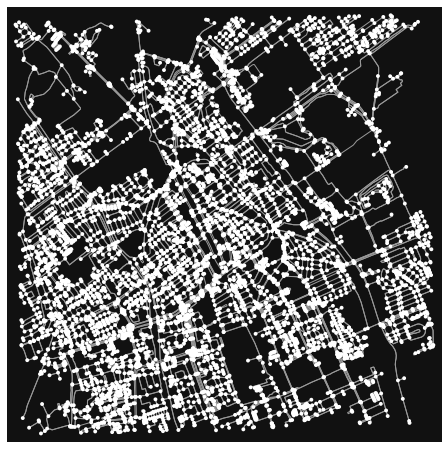

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [44]:
# download cycling network of Delft, using same bbox as tree data
G = ox.graph_from_bbox(north=north, south=south, east=east, west=west, network_type='bike')
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

In [45]:
# convert to gdf
bikeGdf = ox.utils_graph.graph_to_gdfs(G)
bikeNodes = bikeGdf[0].to_crs('EPSG:28992')
bikeEdges = bikeGdf[1].to_crs('EPSG:28992')

In [46]:
bikeEdges.head(2)

osmid     name  \
u        v         key                                                      
21748385 44941583  0    [437653232, 27203786, 27232726, 4240087]  Hazepad   
         526316580 0                                   437654618  Hazepad   

                         highway  oneway   length bridge     width  \
u        v         key                                               
21748385 44941583  0    cycleway   False  135.943    yes  [2, 2.5]   
         526316580 0    cycleway   False   15.454    NaN       2.5   

                                                                 geometry  \
u        v         key                                                      
21748385 44941583  0    LINESTRING (86964.754 449850.980, 86961.975 44...   
         526316580 0    LINESTRING (86964.754 449850.980, 86967.476 44...   

                       maxspeed service lanes access tunnel  ref junction  \
u        v         key                                                      
21748385 44941583  0        NaN     NaN   NaN    NaN    NaN  NaN      NaN   
         526316580 0        NaN     NaN   NaN    NaN    NaN  NaN      NaN   

                       est_width  
u        v         key            
21748385 44941583  0         NaN  
         526316580 0         NaN

In [47]:
bikeNodes.head(2)

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
21748385,52.032815,4.395728,3,NaN,NaN,POINT (86964.754 449850.980)
21748388,52.029774,4.387599,4,NaN,NaN,POINT (86402.308 449520.312)


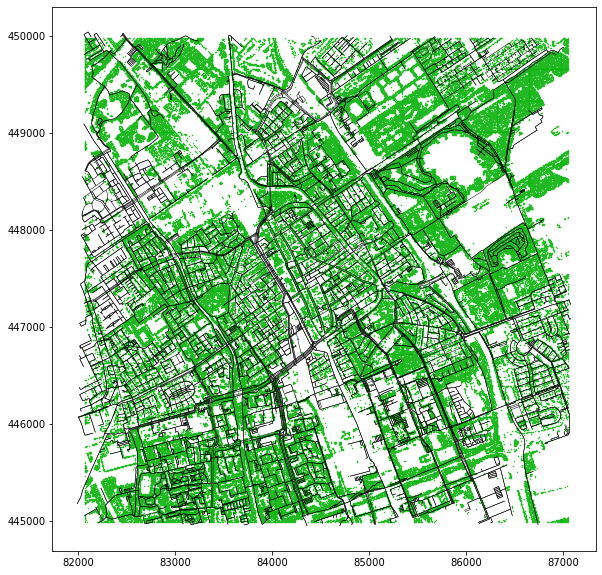

In [84]:
# test plot
fig, ax = plt.subplots(1,1,figsize=(10,10))
treePts.plot(ax=ax, markersize=0.2, color='#0eb511')
bikeEdges.plot(ax=ax, color='black', linewidth=0.5)
plt.show()

In [51]:
# prep for writing shpfile
colList = list(bikeEdges.columns)
colList.remove('geometry')
for col in colList: 
    bikeEdges[col] = bikeEdges[col].map(lambda x: ','.join([str(i) for i in x]) if isinstance(x, list) else x)

In [52]:
for col in bikeEdges.columns: 
    nList = bikeEdges[col].map(lambda x: True if isinstance(x, list) else False).sum()
    if nList > 0: 
        print('{} still has {} list items'.format(col, nList))

In [53]:
# save as network file
ox.io.save_graphml(G, filepath='data/bikePaths.graphml')
bikeEdges.to_file("data/bikePaths_edges.shp")
bikeNodes.to_file("data/bikePaths_nodes.shp")

C:\Users\tpytsui\AppData\Local\Temp\ipykernel_9044\3578507575.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bikeNodes.to_file("data/bikePaths_nodes.shp")


In [54]:
bikeEdges.head()

osmid           name  \
u        v          key                                                       
21748385 44941583   0    437653232,27203786,27232726,4240087        Hazepad   
         526316580  0                              437654618        Hazepad   
21748388 7261978031 0                               27203785  Bieslandseweg   
         44941583   0                               27213712        Hazepad   
         2906401486 0            31694232,143586221,31694231            NaN   

                          highway  oneway   length bridge    width  \
u        v          key                                              
21748385 44941583   0    cycleway   False  135.943    yes    2,2.5   
         526316580  0    cycleway   False   15.454    NaN      2.5   
21748388 7261978031 0    cycleway   False    2.381    NaN        2   
         44941583   0    cycleway   False  544.521    NaN        2   
         2906401486 0    cycleway   False   32.125    yes  2.5,3.5   

                                                                  geometry  \
u        v          key                                                      
21748385 44941583   0    LINESTRING (86964.754 449850.980, 86961.975 44...   
         526316580  0    LINESTRING (86964.754 449850.980, 86967.476 44...   
21748388 7261978031 0    LINESTRING (86402.308 449520.312, 86403.557 44...   
         44941583   0    LINESTRING (86402.308 449520.312, 86433.893 44...   
         2906401486 0    LINESTRING (86402.308 449520.312, 86398.288 44...   

                        maxspeed service lanes access tunnel  ref junction  \
u        v          key                                                      
21748385 44941583   0        NaN     NaN   NaN    NaN    NaN  NaN      NaN   
         526316580  0        NaN     NaN   NaN    NaN    NaN  NaN      NaN   
21748388 7261978031 0        NaN     NaN   NaN    NaN    NaN  NaN      NaN   
         44941583   0        NaN     NaN   NaN    NaN    NaN  NaN      NaN   
         2906401486 0        NaN     NaN   NaN    NaN    NaN  NaN      NaN   

                        est_width  
u        v          key            
21748385 44941583   0         NaN  
         526316580  0         NaN  
21748388 7261978031 0         NaN  
         44941583   0         NaN  
         2906401486 0         NaN

In [55]:
bikeNodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
21748385,52.032815,4.395728,3,NaN,NaN,POINT (86964.754 449850.980)
21748388,52.029774,4.387599,4,NaN,NaN,POINT (86402.308 449520.312)
25315531,52.022649,4.374519,4,NaN,NaN,POINT (85493.661 448740.066)
25315553,52.021946,4.387287,4,NaN,NaN,POINT (86368.859 448649.693)
25315558,52.023895,4.375116,3,NaN,NaN,POINT (85536.559 448878.090)
